In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.bezier as bezier
from scipy.special import comb

In [2]:
class Vector:
    def __init__(self, x, y, ray_profile, angle) -> None:
        self.spatial_x = x
        self.spatial_y = y
        self.magnitude = ray_profile
        self.direction = angle

In [3]:
def rotate(x, y, angle):
    new_x = x * np.cos(angle) - y * np.sin(angle)
    new_y = x * np.sin(angle) + y * np.cos(angle)
    return np.array([new_x, new_y])

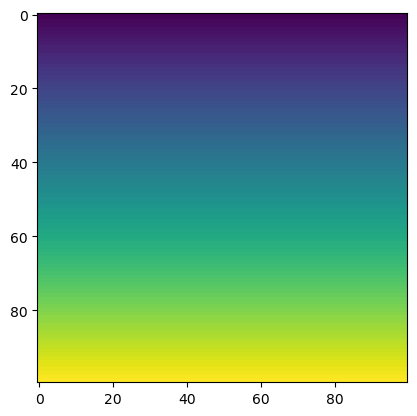

In [4]:
space_size, node_size = 5e-4, 100
beam_half_width = 2e-4
x_space_min, x_space_max, y_space_min, y_space_max = -space_size, space_size, -space_size, space_size
x_node_min, x_node_max, y_node_min, y_node_max = 0, node_size, 0, node_size
xx, yy = np.meshgrid(range(x_node_min, x_node_max), range(y_node_min, y_node_max))
z = yy * 1e-5
plt.imshow(z)

In [5]:
def space_to_node(space_x,space_y):
    node_x = x_node_min + np.floor(x_node_max * (space_x - x_space_min) / (x_space_max - x_space_min))
    node_y = y_node_min + np.floor(y_node_max * (space_y - y_space_min) / (y_space_max - y_space_min))
    return np.array([node_x, node_y])

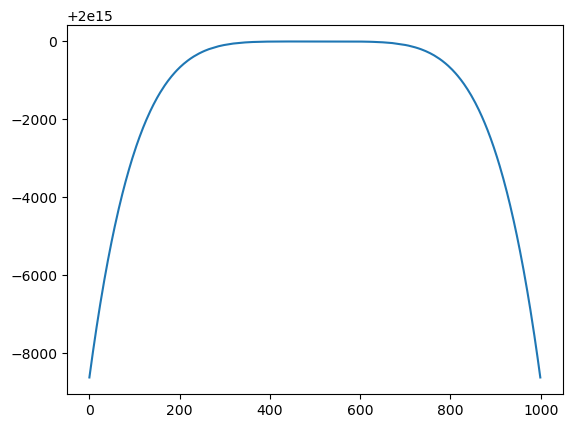

In [6]:
laser_start_points = [(0,50), (50,100)]
beam_normal_directions = [0,np.pi/2] # radians wrt x axis
ray_count_per_beam = 1000

scale_factor = 2e15
beam_profile_range = np.linspace(-beam_half_width, beam_half_width, ray_count_per_beam) # phase_r
beam_profile = scale_factor * np.exp(-((beam_profile_range/.0375)**2)**(5/2)) # pow_r


plt.plot(beam_profile)


(4, 1000)


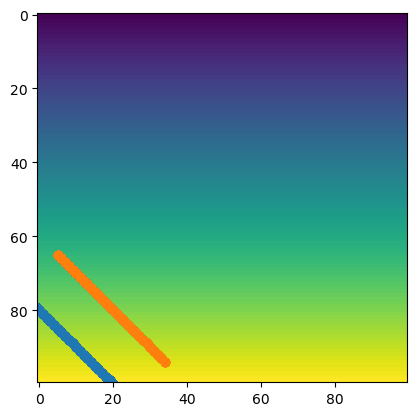

In [8]:
beam_directions = [0, np.pi/4]
beam_positions = [[0,50]]
sp =  np.array([np.zeros(1000), np.linspace(-2e-4,2e-4,1000)])
sp = sp.T
newsp = sp 
direction = -np.pi/4
spatial_position = rotate(*newsp.T, direction).T + [-4e-4,4e-4]
node_positions = space_to_node(*spatial_position.T)

rays = np.vstack((spatial_position.T, beam_profile, np.full(1000,direction)))
next_step = rays.copy()
next_step[0,:] += 1e-4
next_step[1,:] -= 1e-4
print(next_step.shape)
plt.scatter(*node_positions)
plt.scatter(*space_to_node(*next_step[:2,:]))
plt.imshow(z)

# Bezier estimations

In [ ]:
def raster_rays_to_bezier(raster_points, number_of_control_points = 6, tolerance = 5, limit_control_points = 100, plot = False, plot_control = False):
    """
    raster_points: np.array[n, 2] ; n is the number of pixels rastered
    number_of_control_points: starting expected number of control points
    tolerance: difference between raster and bezier
    limit_control_points: max number of control points
    """
    x, y = raster_points.T
    if plot:
        plt.plot(x,y)

    # https://stackoverflow.com/questions/12643079/b%C3%A9zier-curve-fitting-with-scipy
    # solves an arbitrary curve for a bezier using all points. produces a bezier curve with number_of_control_points

    matrix = lambda n, t, k: t ** (k) * (1-t) ** (n-k) * comb(n, k) # n: polynomial degree, t: parameter, k: current term
    get_bezier = lambda parameter_range, num_control_points: np.array([[
        matrix(num_control_points-1, t, k) for k in range(num_control_points)] for t in parameter_range
        ])

    def least_squares_fit(points, matrix):
        matrix_ = np.linalg.pinv(matrix)
        return np.matmul(matrix_,points)

    points = np.array(list(zip(x, y)))
    while True:
        control_points = least_squares_fit(points, get_bezier(np.linspace(0,1,1000),number_of_control_points))
        bezier_curve = bezier.BezierSegment(control_points)
        bezier_plot_points = np.array(bezier_curve.point_at_t(np.linspace(0,1,1000)))
        if(np.sum(np.abs(bezier_plot_points - points)) < tolerance or number_of_control_points >= limit_control_points):
            break
        number_of_control_points += 1
    print("Control Points: ", number_of_control_points, "Difference: ", np.sum(np.abs(bezier_plot_points - points)))
    if plot_control:
        plt.scatter(*control_points.T)
    if plot:
        plt.plot(*bezier_plot_points.T, linestyle='-.')
    return control_points, bezier_curve


Control Points:  11 Difference:  0.49741853832040045


(array([[-3.14159265e+00,  2.48080441e-03],
        [-2.51327412e+00, -3.68708063e-02],
        [-1.88495559e+00,  1.13195028e+00],
        [-1.25663706e+00,  1.51224740e+00],
        [-6.28318531e-01,  6.35751710e+00],
        [-9.23705556e-14, -1.24346776e+01],
        [ 6.28318531e-01,  6.35751710e+00],
        [ 1.25663706e+00,  1.51224740e+00],
        [ 1.88495559e+00,  1.13195028e+00],
        [ 2.51327412e+00, -3.68708063e-02],
        [ 3.14159265e+00,  2.48080441e-03]]),
 <matplotlib.bezier.BezierSegment at 0x2694687f1c0>)

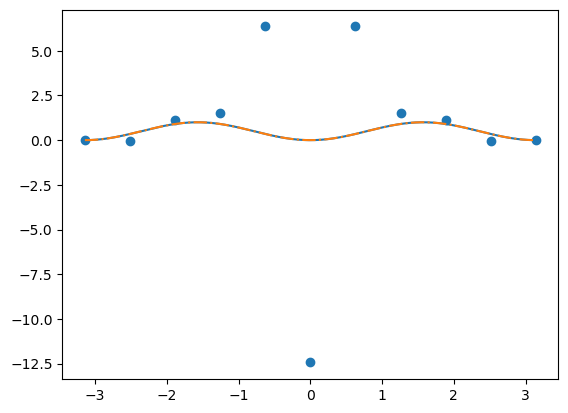

In [3]:
x = np.linspace(-np.pi, np.pi, 1000)
y = np.sin(x) ** 2
raster_rays_to_bezier(np.array([x,y]).T, number_of_control_points = 10, plot =True, plot_control = True)

Control Points:  15 Difference:  26.628065760052518


(array([[-3.14159265e+00,  1.20260578e-01],
        [-2.69279370e+00,  6.64764820e-01],
        [-2.24399475e+00,  5.08709714e+00],
        [-1.79519580e+00, -2.30405929e+01],
        [-1.34639685e+00,  8.49592815e+01],
        [-8.97597901e-01, -1.97106044e+02],
        [-4.48798951e-01,  3.33330322e+02],
        [ 2.50111043e-12, -3.96590918e+02],
        [ 4.48798951e-01,  3.33330322e+02],
        [ 8.97597901e-01, -1.97106044e+02],
        [ 1.34639685e+00,  8.49592815e+01],
        [ 1.79519580e+00, -2.30405929e+01],
        [ 2.24399475e+00,  5.08709714e+00],
        [ 2.69279370e+00,  6.64764820e-01],
        [ 3.14159265e+00,  1.20260578e-01]]),
 <matplotlib.bezier.BezierSegment at 0x26947ab2f70>)

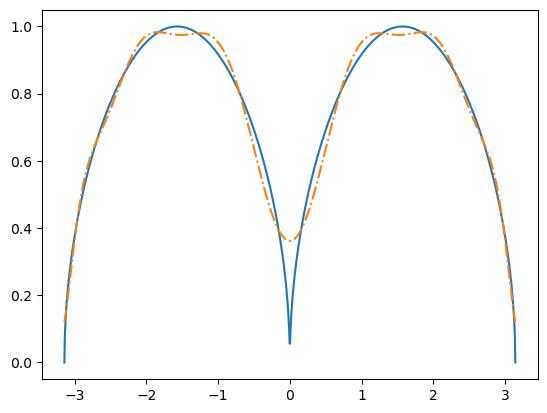

In [4]:
x = np.linspace(-np.pi, np.pi, 1000)
y = np.abs(np.sin(x)) ** (1/2)
raster_rays_to_bezier(np.array([x,y]).T, 1, plot =True, limit_control_points=15)

Control Points:  4 Difference:  8.827172499892288e-12


(array([[ -3.14159265,  16.56243956],
        [ -1.04719755,  40.28277916],
        [  1.04719755, -46.86251543],
        [  3.14159265,   3.17676924]]),
 <matplotlib.bezier.BezierSegment at 0x26947b3e250>)

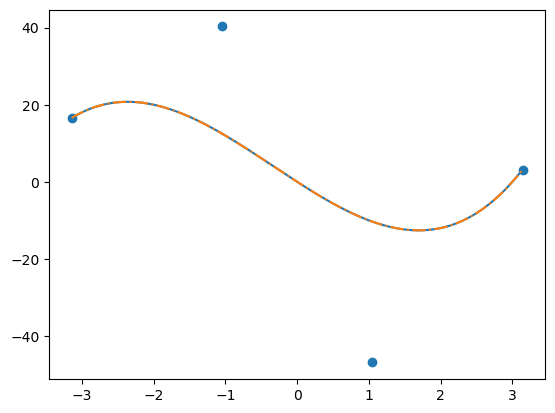

In [5]:
x = np.linspace(-np.pi, np.pi, 1000)
y = (x-3) * (x + 4) * x
raster_rays_to_bezier(np.array([x,y]).T, 1, plot=True, plot_control=True)

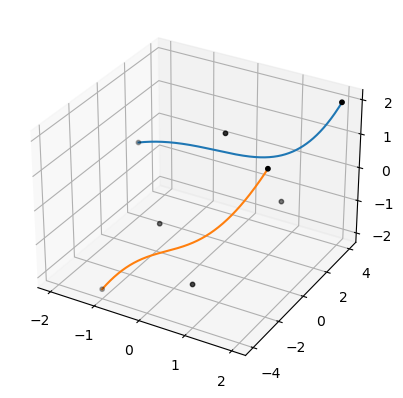

In [6]:
control_points = np.array([[[-2,2,0],[0,2,1],[1,3,-1],[2,4,2]],[[-1,-4,-2],[0,-3,0],[1,-4,-1],[2,-2,2]]])

beziers = list()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for control_point in control_points:
    bezier_curve = bezier.BezierSegment(control_point)
    beziers.append(bezier_curve)
    bezier_raster = np.array(bezier_curve.point_at_t(np.linspace(0,1,1000)))

#     print(control_point.shape)
    ax.scatter3D(*control_point.T,s=10,c='black')
#     print(bezier_raster)
    plt.plot(*bezier_raster.T)

In [14]:
grid = np.empty((4,4,3))

for i in range(4):
    for j in range(4):
        grid[j, i] = np.cross(control_points[1][i], control_points[0][j])
grid = grid.T.reshape((4,4,3))
print(grid)

[[[-6. -4. -3.]
  [-6. -8. -2.]
  [ 1.  2. -6.]
  [ 2.  6. 12.]]

 [[ 0.  4.  6.]
  [12. -6. -4.]
  [-3. -6. -8.]
  [-2.  1.  2.]]

 [[-6.  2.  6.]
  [12.  0.  4.]
  [ 6. 12. -6.]
  [-4. -3. -6.]]

 [[-8. -2.  1.]
  [ 2. -6.  2.]
  [ 6. 12.  0.]
  [ 4.  6. 12.]]]


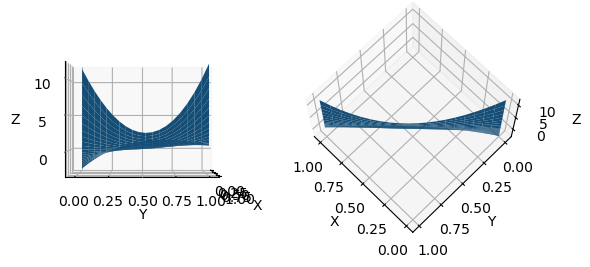

In [31]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
u, v = np.linspace(0,1,20), np.linspace(0,1,20)
uu, vv = np.meshgrid(u, v)

x = np.zeros_like(uu)
y = np.zeros_like(vv)
z = np.zeros_like(uu)

for i in range(4):
    for j in range(4):
        x += grid[i, j, 0] * np.power(uu, i) * np.power(1 - uu, 3 - i) * np.power(vv, j) * np.power(1 - vv, 3 - j)
        y += grid[i, j, 1] * np.power(uu, i) * np.power(1 - uu, 3 - i) * np.power(vv, j) * np.power(1 - vv, 3 - j)        
        z += grid[i, j, 2] * np.power(uu, i) * np.power(1 - uu, 3 - i) * np.power(vv, j) * np.power(1 - vv, 3 - j)        
        
fig = plt.figure()
ax = fig.add_subplot(121, projection = '3d')
ax.plot_surface(u, v, z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(0, 0)

ax = fig.add_subplot(122, projection = '3d')
ax.plot_surface(u, v, z)
# axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


ax.view_init(70, 135)



The plot above is for a 1D beam (technically a ray, I guess). The z value is supposed to show the intensity. I messed up the math for the actual projection, but the raster_rays_to_bezier function would produce required number of control points for the intensity map to a desired degree of precision to the actual raster. The same solution (least squares surface) would work for a 2D beam with a bezier surface defined in xyz-space with the xy-plane for position and the z-value for intensity.
Raising the dimension once again would allow a 3D beam to be defined in the xyzw-space; w for intensity. least squares over 3(?)-dimensions for the bezier volume fit.

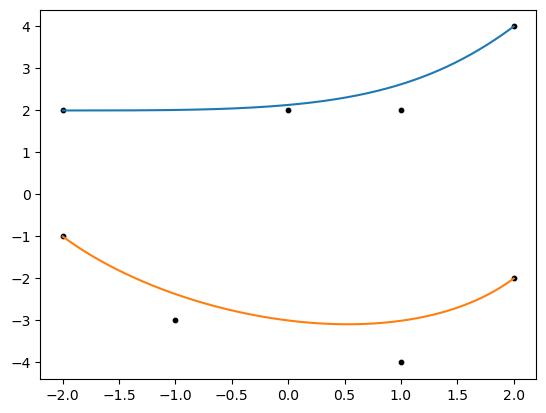

In [11]:
control_points = np.array([[[-2,2],[0,2],[1,2],[2,4]],[[-2,-1],[-1,-3],[1,-4],[2,-2]]])
%matplotlib inline
beziers = list()
fig = plt.figure()
ax = fig.add_subplot(111)
for control_point in control_points:
    bezier_curve = bezier.BezierSegment(control_point)
    beziers.append(bezier_curve)
    bezier_raster = np.array(bezier_curve.point_at_t(np.linspace(0,1,1000)))

#     print(control_point.shape)
    ax.scatter(*control_point.T,s=10,c='black')
#     print(bezier_raster)
    plt.plot(*bezier_raster.T)

    

In [12]:
grid = np.empty((4,4,2))

for i in range(4):
    for j in range(4):
        grid[j, i] = np.cross(control_points[1][i], control_points[0][j])
# grid = grid.T.reshape((4,4,2))
print(grid)

[[[-6. -6.]
  [-8. -8.]
  [-6. -6.]
  [ 0.  0.]]

 [[-4. -4.]
  [-2. -2.]
  [ 2.  2.]
  [ 4.  4.]]

 [[-3. -3.]
  [ 1.  1.]
  [ 6.  6.]
  [ 6.  6.]]

 [[-6. -6.]
  [ 2.  2.]
  [12. 12.]
  [12. 12.]]]
